In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import jax.random as random
import numpyro
from numpyro.infer import MCMC, NUTS
import tarea

# ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [3]:
df = pd.read_csv('data/billonarios.csv', index_col='pais')
display(df.head(5))
y = df["nbillonarios"].values
x  = df.drop("nbillonarios", axis=1).values
display(y.shape, x.shape)

nbillonarios   logpibpc     logpob  gatt
pais                                                   
United States           469  10.786021  19.532846    60
Canada                   25  10.743365  17.319439     0
Bahamas, The              0  10.072139  12.760934     0
Aruba                     0  10.223734  11.526276     0
Bermuda                   0  11.446847  11.086334     0

(197,)

(197, 3)

## Modelo 

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente


## Actividades

- Implemente el modelo usando numpyro (función `model` en `tarea.py`)
    - Considere un prior normal para los parámetros $\theta$
    - Considere una verosimilitud poisson
- Obtenga muestras del posterior utilizando MCMC
    - Muestre las trazas de los parámetros (utilize `matplotlib`)
    - Diagnóstique la convergencia en base a las trazas, número de muestras efectivo y el estadístico de Gelman-Rubin
- Análisis los resultados obtenidos
    - Muestre el posterior de los parámetros obtenidos (utilize `matplotlib`), ¿Cúales son significativamente distintos de cero?
    - Prediga la cantidad de billonarios y la incertidumbre asociada de cada pais usando su modelo (posterior predictivo. 
    - Responda y discuta ¿Cuáles son los 5 países con mayor error entre la predicción y el valor real? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia? ¿Cuáles son los 5 paises donde el modelo está más inseguro de sus resultados?

In [4]:
seeded_model = numpyro.handlers.seed(tarea.model, random.PRNGKey(12345))
exec_trace = numpyro.handlers.trace(seeded_model).get_trace(x, y)
print(numpyro.util.format_shapes(exec_trace))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Trace Shapes:        
 Param Sites:        
Sample Sites:        
   theta dist     | 4
        value     | 4
   data plate 197 |  
       y dist 197 |  
        value 197 |  


/tmp/ipykernel_10581/3563545572.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4)
sample: 100%|████████████████████████████████████| 1500/1500 [00:00<00:00, 4753.75it/s, 7 steps of size 6.59e-03. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]    -21.81      0.48    -21.81    -22.59    -20.99    713.13      1.01
  theta[1]      0.80      0.03      0.79      0.75      0.84    961.21      1.01
  theta[2]      0.92      0.02      0.92      0.89      0.95    854.13      1.01
  theta[3]      0.01      0.00      0.01      0.01      0.02   1951.17      1.00

Number of divergences: 0
Top 5 países con mayor error:
Index(['Italy', 'France', 'Russian Federation', 'Japan', 'United States'], dtype='object', name='pais')

Países con exceso de billonarios:
Index(['United States', 'Canada', 'Belize', 'Ireland', 'Monaco', 'Cyprus',
       'Russian Federation', 'Ukraine', 'Sweden', 'Iceland', 'Turkey',
       'Lebanon', 'Israel', 'Saudi Arabia', 'Kuwait', 'United Arab Emirates',
       'Kazakhstan', 'India', 'Malaysia', 'Singapore', 'New Zealand',
       'Hong Kong SAR, China'],
      dtype='object', name='pais')

Países con menos billonarios de lo es

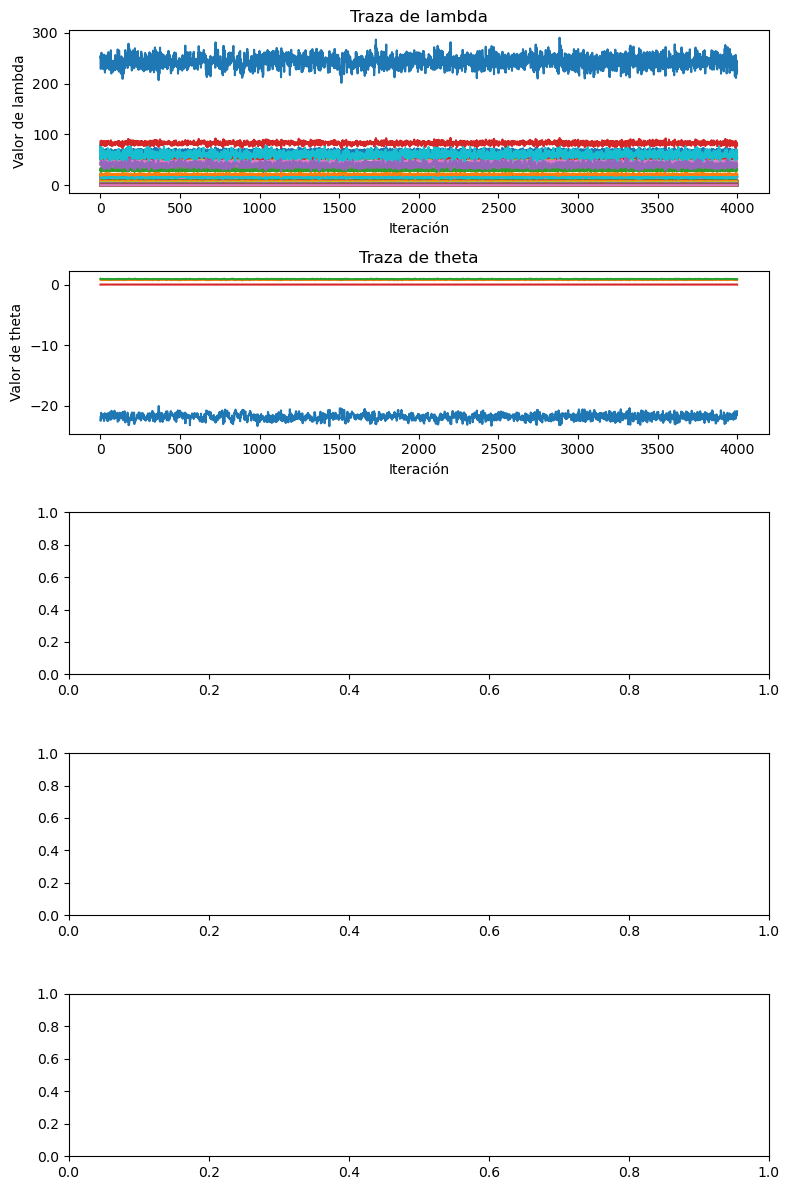

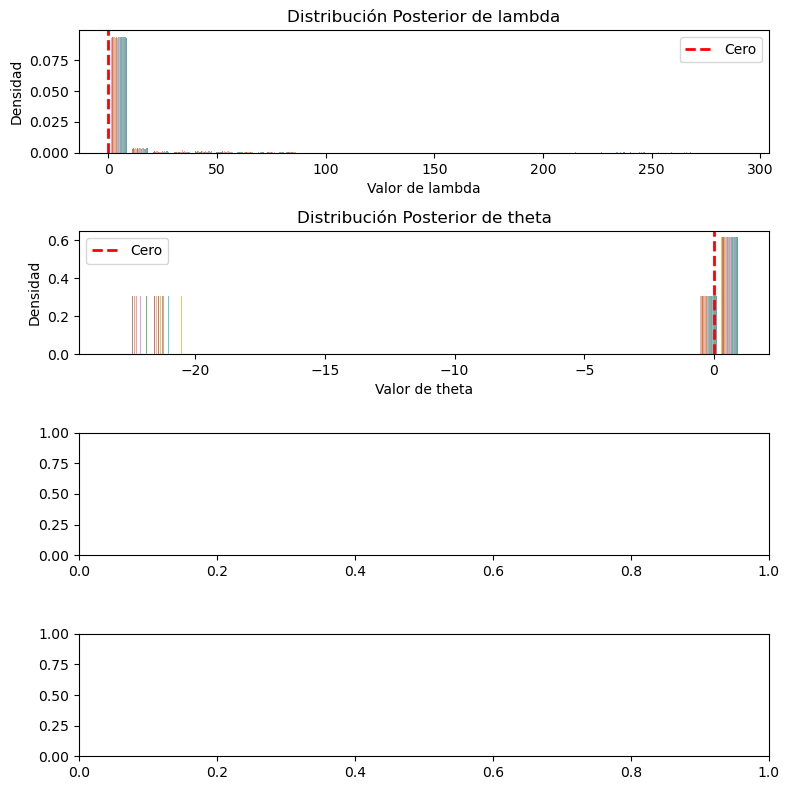

In [7]:
# Inicializar el modelo y el muestreador NUTS
nuts_kernel = NUTS(tarea.model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000, num_chains=4)

# Muestrear el posterior
mcmc.run(random.PRNGKey(0), x, y)
samples = mcmc.get_samples()


# Visualizar trazas de los parámetros
fig, axs = plt.subplots(nrows=5, figsize=(8, 12), tight_layout=True)  # Ajustar el espaciado automáticamente
for i, param in enumerate(samples.keys()):
    if param in samples:
        axs[i].plot(samples[param])
        axs[i].set_title(f'Traza de {param}')
        axs[i].set_xlabel('Iteración')
        axs[i].set_ylabel(f'Valor de {param}')

# Diagnóstico de convergencia
mcmc.print_summary()

# Visualizar posterior de los parámetros
fig, axs = plt.subplots(nrows=4, figsize=(8, 8), tight_layout=True)  # Ajustar el espaciado automáticamente
for i, param in enumerate(samples.keys()):
    if param in samples:
        axs[i].hist(samples[param], bins=30, density=True, alpha=0.7)
        axs[i].set_title(f'Distribución Posterior de {param}')
        axs[i].set_xlabel(f'Valor de {param}')
        axs[i].set_ylabel('Densidad')
        axs[i].axvline(0, color='red', linestyle='dashed', linewidth=2, label='Cero')
        axs[i].legend()

# Predicción y análisis de resultados
posterior_lambda = samples['lambda']
predicted_y = np.mean(posterior_lambda, axis=0)
prediction_std = np.std(posterior_lambda, axis=0)

# Calcular error entre predicción y valor real
prediction_error = np.abs(predicted_y - y)

# Obtener los 5 países con mayor error
top_error_indices = np.argsort(prediction_error)[-5:]
top_error_countries = df.index[top_error_indices]

# Filtrar países con exceso de billonarios y menos billonarios de lo esperado
excess_billionaires = df[df['nbillonarios'] > predicted_y]
deficient_billionaires = df[df['nbillonarios'] < predicted_y]

# Analizar Rusia
russia_index = df.index.get_loc('Russian Federation')
russia_predicted = predicted_y[russia_index]
russia_actual = y[russia_index]

# Obtener los 5 países con mayor incertidumbre
uncertainty_indices = np.argsort(prediction_std)[-5:]
uncertainty_countries = df.index[uncertainty_indices]

# Imprimir resultados
print("Top 5 países con mayor error:")
print(top_error_countries)
print("\nPaíses con exceso de billonarios:")
print(excess_billionaires.index)
print("\nPaíses con menos billonarios de lo esperado:")
print(deficient_billionaires.index)
print("\nPredicción y valor real para Rusia:")
print(f"Predicción: {russia_predicted}, Valor real: {russia_actual}")
print("\nTop 5 países con mayor incertidumbre:")
print(uncertainty_countries)


plt.show()


#### Parámetros del Modelo:
theta[0]: El parámetro theta[0] tiene una media de -21.81, lo que significa que la log-intensidad base es negativa. La desviación estándar es 0.48, y el intervalo de confianza del 95% va desde -22.59 hasta -20.99. El estadístico R-hat está cerca de 1 (1.01), lo que indica convergencia adecuada.

theta[1] y theta[2]: Los parámetros theta[1] y theta[2] también tienen medias y desviaciones estándar razonables, indicando que las variables predictoras tienen un impacto positivo en la log-intensidad. Los intervalos de confianza del 95% están relativamente estrechos.

theta[3]: El parámetro theta[3], asociado con la variable 'gatt', tiene una media baja (0.01), lo que sugiere un impacto limitado. El intervalo de confianza del 95% va desde 0.01 hasta 0.02.

#### Diagnóstico de Convergencia:
El número efectivo de muestras (n_eff) para todos los parámetros es bastante alto, lo que es positivo para la convergencia del modelo.
El estadístico R-hat es cercano a 1 para todos los parámetros, indicando convergencia adecuada.


### Resultados:

#### Top 5 países con mayor error: 

Los países con mayor error entre la predicción y el valor real son 'Italy', 'France', 'Russian Federation', 'Japan', y 'United States'.

#### Países con exceso de billonarios:
Entre los países con exceso de billonarios se encuentran 'United States', 'Canada', 'Belize', 'Ireland', 'Monaco', entre otros.

#### Países con menos billonarios de lo esperado: 
Entre los países con menos billonarios de lo esperado se encuentran 'Bahamas, 'Aruba', 'Bermuda', 'Cuba', 'Haiti', entre otros.

#### Predicción y valor real para Rusia: 
La predicción para Rusia es 29.38, mientras que el valor real es 87. Esto sugiere una discrepancia sustancial entre la predicción del modelo y la realidad.

#### Top 5 países con mayor incertidumbre: 
Los países con mayor incertidumbre en las predicciones son 'Germany', 'Japan', 'India', 'China', y 'United States'.

#### Conclusiones 
En general, estos resultados indican que el modelo tiene dificultades para hacer predicciones precisas, especialmente para ciertos países. La discrepancia en Rusia y la incertidumbre en algunos países destacan áreas donde el modelo puede necesitar mejoras o ajustes como por ejemplo:

##### 1. Características del Modelo:

Se propone la exploración de modelos más complejos o flexibles que puedan capturar con mayor precisión las relaciones subyacentes en los datos. La consideración de modelos jerárquicos o no lineales podría ser beneficiosa.

##### 2. Características de los Datos:

Se sugiere la posibilidad de incluir nuevas características relevantes o revisar la normalización y transformación de las características existentes para mejorar la capacidad predictiva del modelo.

##### 3. Hiperparámetros del Modelo:

Para optimizar el rendimiento del modelo, se recomienda experimentar con diferentes valores de hiperparámetros, como la tasa de aprendizaje, el número de iteraciones, o la forma de las distribuciones prior utilizadas.